<a href="https://colab.research.google.com/github/Patelzeelr/Boston-Housing-Data/blob/main/ALY6110_MOD2_Case_Study_ZeelPatel_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
   from google.colab import drive

   drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=200374f2df059a9ba1519c69fa5bf72be17a9c5cad32cf7d0e81b48f1cdaddd2
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [3]:
from google.colab import files
uploaded_files = files.upload()

Saving BostonHousing.csv to BostonHousing.csv


In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,floor, avg, count, stddev, min, max, expr, sum as spark_sum

# Start a Spark session
spark_session = SparkSession.builder.appName("BostonHousingAnalysis").getOrCreate()

# Load the dataset
file_path = "BostonHousing.csv"
data = spark_session.read.csv(file_path, header=True, inferSchema=True)



In [6]:
# Show the first few rows of the dataset
data.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



In [7]:
# Check for missing values in each column
missing_values = data.select([spark_sum(col(column).isNull().cast("int")).alias(column) for column in data.columns])
missing_values.show()

+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+
|crim| zn|indus|chas|nox| rm|age|dis|rad|tax|ptratio|  b|lstat|medv|
+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+
|   0|  0|    0|   0|  0|  0|  0|  0|  0|  0|      0|  0|    0|   0|
+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+



In [9]:
# Show the schema of the dataset
print("Schema of the dataset:")
data.printSchema()

Schema of the dataset:
root
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- b: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



In [10]:
# Describe the dataset to get summary statistics
print("Summary statistics of the dataset:")
data.describe().show()

# Get the number of rows and columns
num_rows = data.count()
num_columns = len(data.columns)
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")


Summary statistics of the dataset:
+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|              crim|                zn|             indus|              chas|                nox|                rm|               age|              dis|              rad|               tax|           ptratio|                 b|             lstat|              medv|
+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  count|               506|               506|               506|               506|                506|               506|               5

In [11]:
# Create bins based on the average number of rooms
data = data.withColumn("RM_bin", floor(data["RM"]))

data.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+------+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|RM_bin|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+------+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|     6|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|     6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|     7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|     6|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|     7|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+------+
only showing top 5 rows



In [17]:
from pyspark.sql.functions import avg, count, stddev, min, max

# Calculate statistics for "MEDV" in each bin
statistics = data.groupBy("RM_bin").agg(
    count("MEDV").alias("count"),
    avg("MEDV").alias("avg_MEDV"),
    stddev("MEDV").alias("stddev_MEDV"),
    min("MEDV").alias("min_MEDV"),
    max("MEDV").alias("max_MEDV")
).orderBy("RM_bin")

# Show the statistics for each bin
statistics.show()


+------+-----+------------------+------------------+--------+--------+
|RM_bin|count|          avg_MEDV|       stddev_MEDV|min_MEDV|max_MEDV|
+------+-----+------------------+------------------+--------+--------+
|     3|    2|              25.3|3.1112698372208083|    23.1|    27.5|
|     4|   13|16.023076923076925|10.943959813991297|     7.0|    50.0|
|     5|  158|17.487341772151893| 5.352667460226968|     5.0|    50.0|
|     6|  269| 22.01598513011151| 6.467721594707344|     7.2|    50.0|
|     7|   51|36.917647058823526| 8.316362326939656|    15.0|    50.0|
|     8|   13|              44.2| 8.092383250110357|    21.9|    50.0|
+------+-----+------------------+------------------+--------+--------+



<ipython-input-13-c1a0d7d22160>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RM_bin', y='avg_MEDV', data=statistics_pd, palette='viridis')
<ipython-input-13-c1a0d7d22160>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RM_bin', y='stddev_MEDV', data=statistics_pd, palette='viridis')
<ipython-input-13-c1a0d7d22160>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RM_bin', y='min_MEDV', data=statistics_pd, palette='viridis')
<ipython-input-13-c1a0d7d22160>:33: FutureWarning: 

Passing `palette` without assigning `hue` is depre

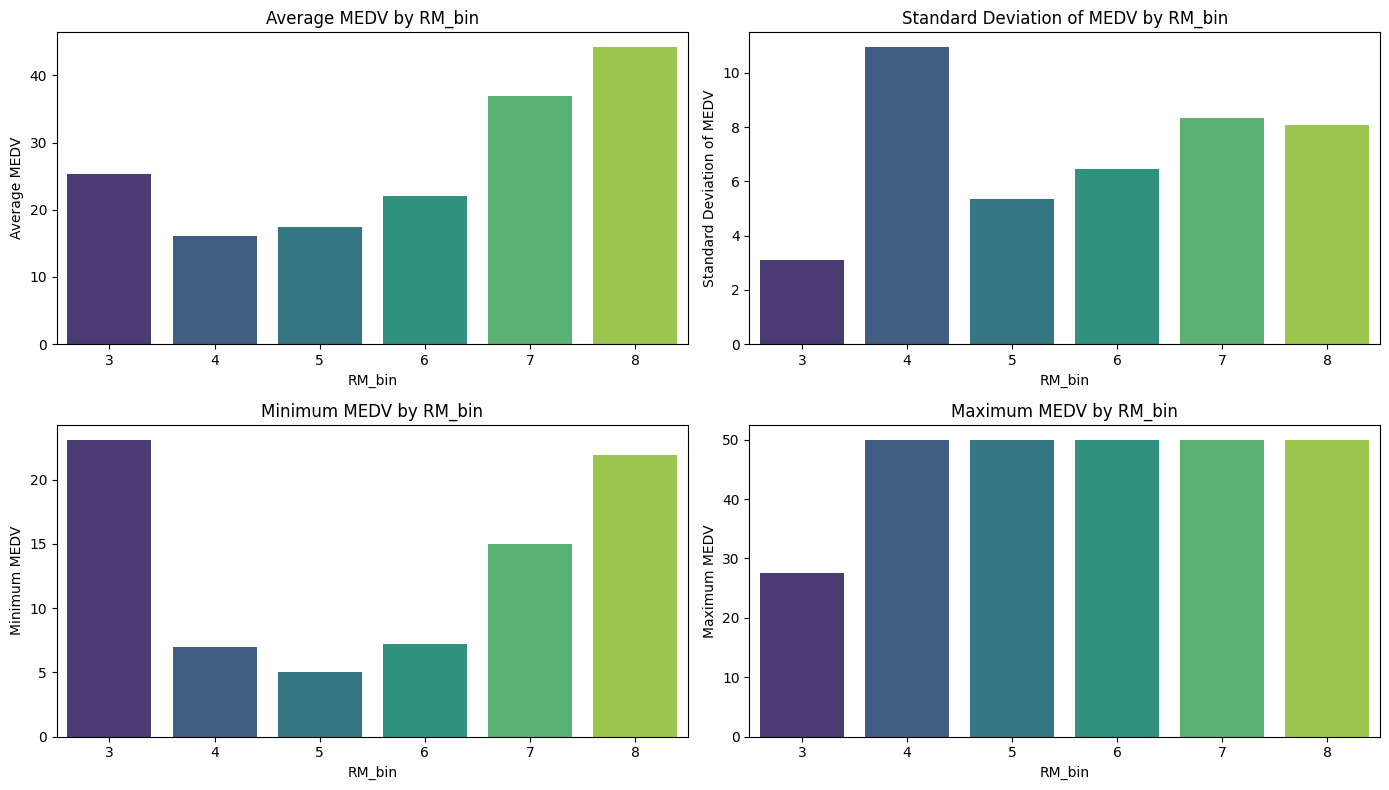

In [13]:
# Convert the Spark DataFrame to a Pandas DataFrame for visualization
statistics_pd = statistics.toPandas()

# Plot bar charts for each statistic
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))

# Average MEDV by RM_bin
plt.subplot(2, 2, 1)
sns.barplot(x='RM_bin', y='avg_MEDV', data=statistics_pd, palette='viridis')
plt.title('Average MEDV by RM_bin')
plt.xlabel('RM_bin')
plt.ylabel('Average MEDV')

# Standard Deviation of MEDV by RM_bin
plt.subplot(2, 2, 2)
sns.barplot(x='RM_bin', y='stddev_MEDV', data=statistics_pd, palette='viridis')
plt.title('Standard Deviation of MEDV by RM_bin')
plt.xlabel('RM_bin')
plt.ylabel('Standard Deviation of MEDV')

# Minimum MEDV by RM_bin
plt.subplot(2, 2, 3)
sns.barplot(x='RM_bin', y='min_MEDV', data=statistics_pd, palette='viridis')
plt.title('Minimum MEDV by RM_bin')
plt.xlabel('RM_bin')
plt.ylabel('Minimum MEDV')

# Maximum MEDV by RM_bin
plt.subplot(2, 2, 4)
sns.barplot(x='RM_bin', y='max_MEDV', data=statistics_pd, palette='viridis')
plt.title('Maximum MEDV by RM_bin')
plt.xlabel('RM_bin')
plt.ylabel('Maximum MEDV')

plt.tight_layout()
plt.show()


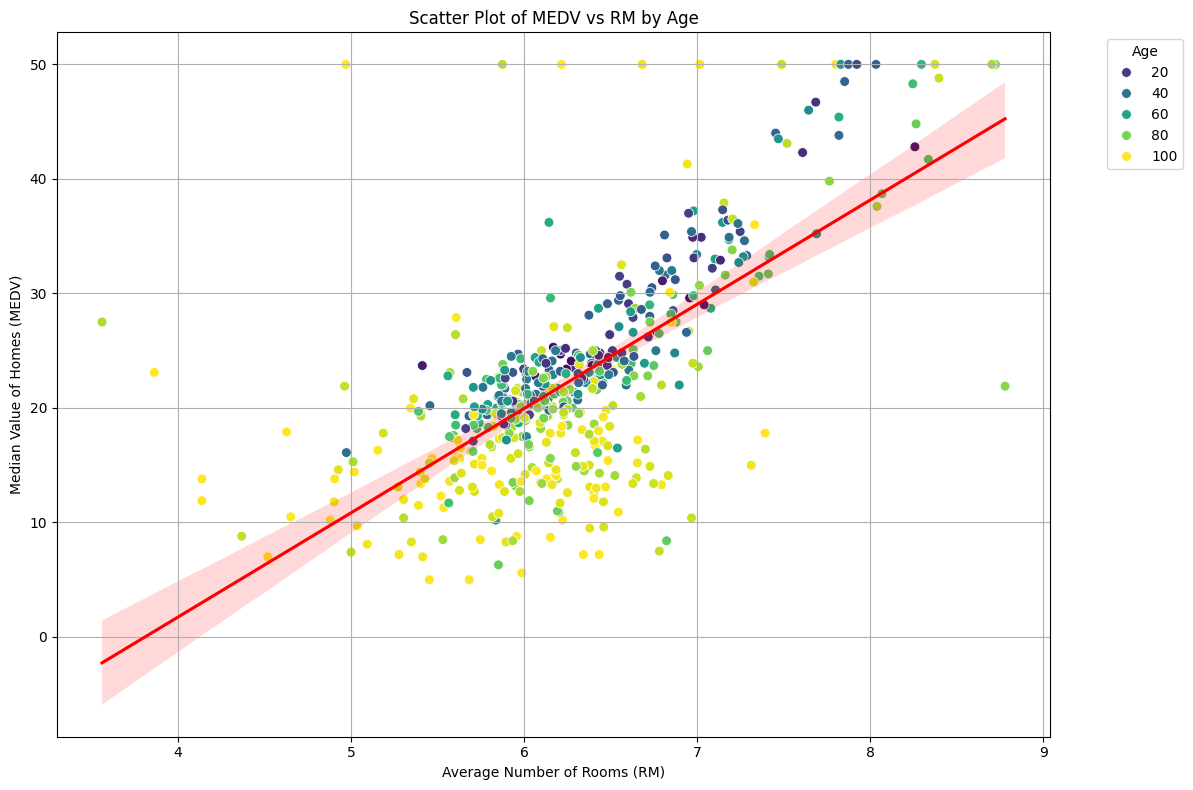

In [14]:
# Convert the Spark DataFrame to a Pandas DataFrame
data_pd = data.select("RM", "MEDV", "AGE").toPandas()

# Plot scatter plot with regression line and color-coded by age
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x='RM', y='MEDV', hue='AGE', palette='viridis', data=data_pd, s=50)
reg_plot = sns.regplot(x='RM', y='MEDV', data=data_pd, scatter=False, color='red')

# Customize the plot
plt.title('Scatter Plot of MEDV vs RM by Age')
plt.xlabel('Average Number of Rooms (RM)')
plt.ylabel('Median Value of Homes (MEDV)')
plt.grid(True)
plt.legend(title='Age', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

<ipython-input-15-37da857a41ff>:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data_pd['MEDV'], bins=30, kde=True, palette='plasma')


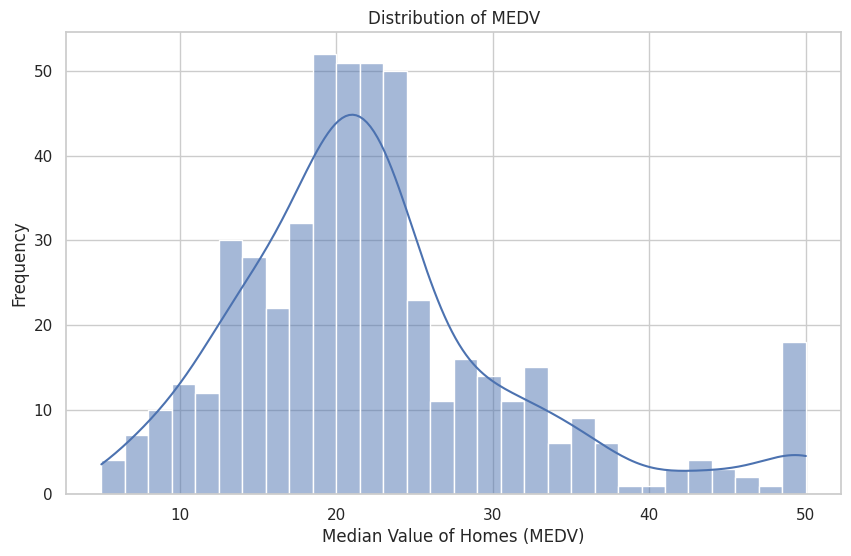

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a colorful style for Seaborn
sns.set(style="whitegrid")

# Create a colorful histogram of MEDV
plt.figure(figsize=(10, 6))
sns.histplot(data_pd['MEDV'], bins=30, kde=True, palette='plasma')
plt.title('Distribution of MEDV')
plt.xlabel('Median Value of Homes (MEDV)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


<ipython-input-28-a0baccca9558>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="RM_bin", y="mean_age", data=grouped_pd_df, palette="Set1")


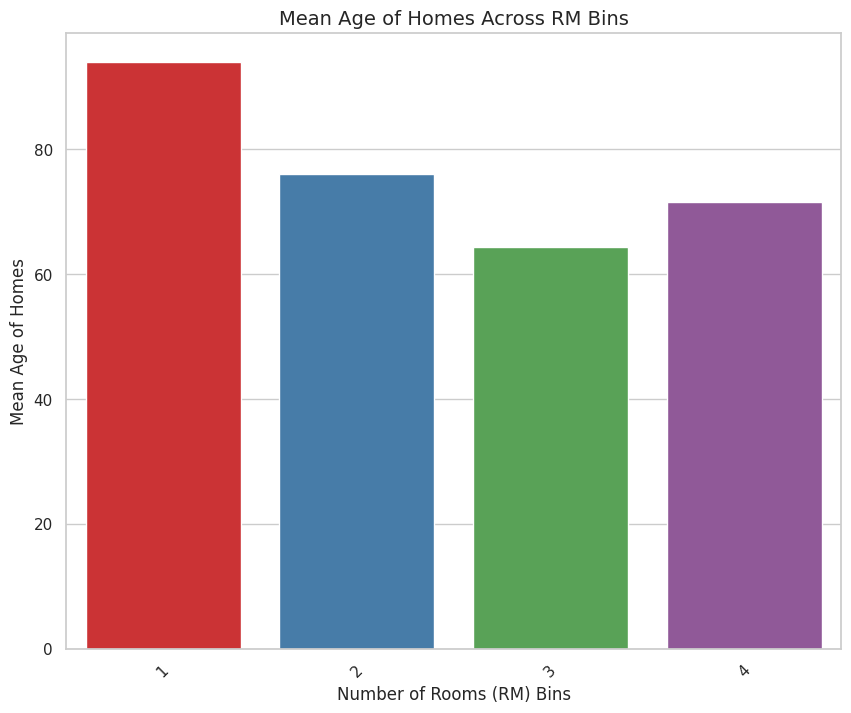

In [28]:
# Calculate average age (AGE) and tax (TAX) by RM bins
data_with_bins = data.withColumn("RM_bin", floor(col("RM")/2))
grouped_data = data_with_bins.groupBy("RM_bin").agg(
    avg("AGE").alias("mean_age"),
    avg("TAX").alias("mean_tax")
)

# Convert PySpark DataFrame to Pandas DataFrame for plotting with Seaborn
grouped_pd_df = grouped_data.toPandas()

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x="RM_bin", y="mean_age", data=grouped_pd_df, palette="Set1")
plt.xlabel("Number of Rooms (RM) Bins", fontsize=12)
plt.ylabel("Mean Age of Homes", fontsize=12)
plt.title("Mean Age of Homes Across RM Bins", fontsize=14)
plt.xticks(rotation=45)
plt.show()

<ipython-input-40-04a9cdd80c5a>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="RM_bin", y="AGE", data=data_for_boxplot_age, palette=custom_palette)
<ipython-input-40-04a9cdd80c5a>:10: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x="RM_bin", y="AGE", data=data_for_boxplot_age, palette=custom_palette)


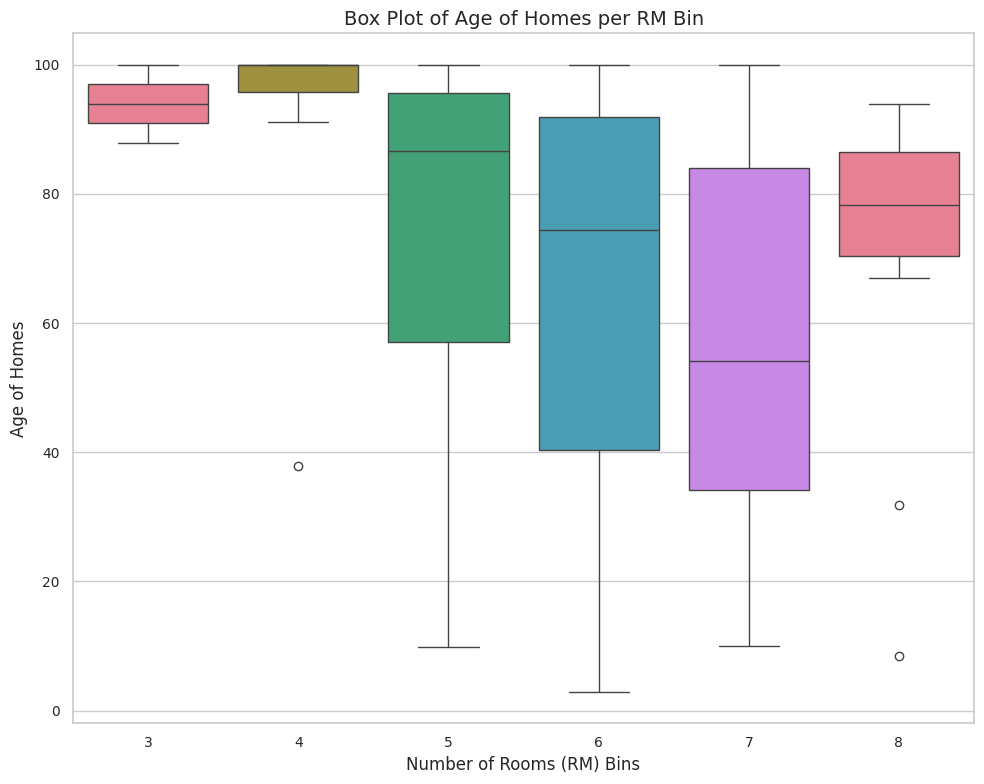

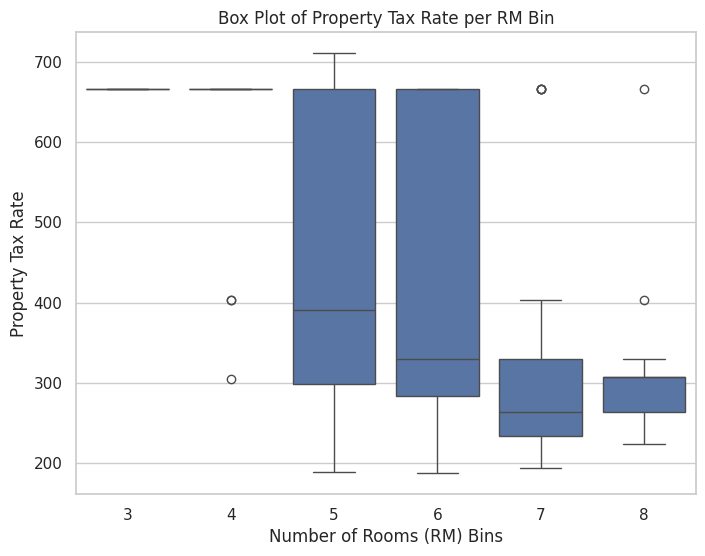

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a custom color palette
custom_palette = sns.color_palette("husl", 5)  # Using 5 distinct colors from the 'husl' palette

# Violin plot of AGE values per RM bin with custom colors
plt.figure(figsize=(10, 8))
data_for_boxplot_age = data.select("RM_bin", "AGE").toPandas()
sns.boxplot(x="RM_bin", y="AGE", data=data_for_boxplot_age, palette=custom_palette)
plt.xlabel("Number of Rooms (RM) Bins", fontsize=12)
plt.ylabel("Age of Homes", fontsize=12)
plt.title("Box Plot of Age of Homes per RM Bin", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Violin plot of TAX values per RM bin
plt.figure(figsize=(8, 6))
data_for_boxplot_tax = data.select("RM_bin", "TAX").toPandas()
sns.boxplot(x="RM_bin", y="TAX", data=data_for_boxplot_tax)
plt.xlabel("Number of Rooms (RM) Bins")
plt.ylabel("Property Tax Rate")
plt.title("Box Plot of Property Tax Rate per RM Bin")
plt.show()
